In [427]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np

# COMPARANDO A RESPOSTA DA PLANTA
- Definindo as funções de transferência da planta e do controlador, encontrados anteriormente

In [428]:
s = ctl.TransferFunction.s
K, a, b = (0.5594463965947698, -44.561536481460486, -44.5638349542396)

G = 0.1975236421*(0.03252359073*s + 1.0)/(1.0*s - 0.49401493)
C =  K * (s - a) * (s - b) / s
C

TransferFunction(array([5.59446397e-01, 4.98608679e+01, 1.11096709e+03]), array([1, 0]))

- Fechando a malha adotando $H(s) = 1$

In [429]:
G_feedback = ctl.feedback(G*C, 1)
G_feedback

TransferFunction(array([3.59398329e-03, 4.30818985e-01, 1.69857507e+01, 2.19442266e+02]), array([3.59398329e-03, 1.43081899e+00, 1.64917358e+01, 2.19442266e+02]))

- Definindo o período de amostragem e convertendo a função de transferência para o domínio $Z$

In [430]:
T = 0.01

G_z_feedback = ctl.c2d(G_feedback, T, method='zoh')
G_z_feedback

TransferFunction(array([ 1.        , -2.53774277,  2.21700278, -0.66467133]), array([ 1.        , -1.89775901,  0.93101183, -0.01866415]), 0.01)

- Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada

In [431]:
num, den = ctl.tfdata(G_z_feedback)
num = np.squeeze(num)
den = np.squeeze(den)

num = num/den[0]
den = den/den[0]

print(num)
print(den)

[ 1.         -2.53774277  2.21700278 -0.66467133]
[ 1.         -1.89775901  0.93101183 -0.01866415]


In [432]:
out = ''

for i in range(0, len(num)):
    out += f'{num[i]}*X_n{i} + '

for i in range(1, len(den)):
    out += f'+ {-1*den[i]}*Y_n{i}'

out = out.replace('X_n0', 'X_n').replace('+ +', '+').replace('+ -', '-')
out

'1.0*X_n -2.5377427672570327*X_n1 + 2.21700277910914*X_n2 -0.6646713337844465*X_n3 + 1.8977590093711272*Y_n1-0.9310118335528617*Y_n2+ 0.018664146114073663*Y_n3'

- Agora é possível encontra a saída do sistema em malha fechada dada uma entrada $X_n$, no caso de um degrau unitário, é só fazer $X_n = 1$ para todo $n$

In [433]:
Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

def computeController(X_n):
    global Y_n1, Y_n2, Y_n3
    global X_n1, X_n2, X_n3

    Y_n = eval(out)

    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n

    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n

- Comparando graficamente as 2 soluções

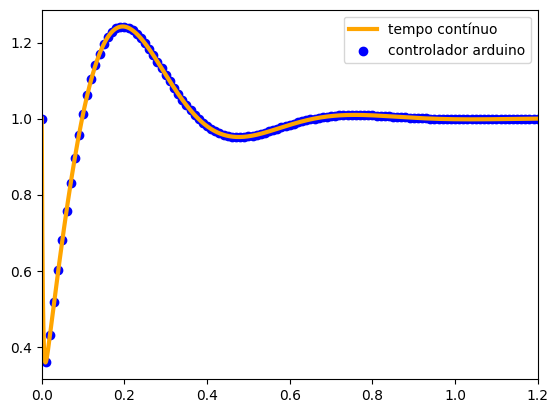

In [434]:
time, response = ctl.step_response(G_feedback)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0
time     = np.arange(0, 5, T)
response = [computeController(1) for i in time] # degrau
plt.scatter(time, response, color='blue', label='controlador arduino')

# PLOTANDO OS GRÁFICOS
plt.xlim([0, 1.2])
plt.legend()
plt.show()

# COMPARANDO A RESPOSTA DO CONTROLADOR
$T(s) = \frac{G(s)C(s)}{1 + G(s)C(s)}$

In [435]:
G_z = ctl.c2d(G, T, method='zoh')
G_z

TransferFunction(array([ 0.00642418, -0.00444405]), array([ 1.        , -1.00495237]), 0.01)

In [436]:
z = sp.var('z')
C = sp.var('C')

G = sympyFunction(G)
G_feedback = sympyFunction(G_feedback)

display(G)
display(G_feedback)

(0.0064241780951594*z + 0.1975236421)/(1.0*z - 0.49401493)

(0.00359398328641998*z**3 + 0.430818985150999*z**2 + 16.9857506821835*z + 219.44226627898)/(0.00359398328641998*z**3 + 1.430818985151*z**2 + 16.4917357521835*z + 219.44226627898)

In [437]:
eq = sp.Eq(G_feedback, (G*C)/(1+G*C))
eq

Eq((0.00359398328641998*z**3 + 0.430818985150999*z**2 + 16.9857506821835*z + 219.44226627898)/(0.00359398328641998*z**3 + 1.430818985151*z**2 + 16.4917357521835*z + 219.44226627898), C*(0.0064241780951594*z + 0.1975236421)/((1.0*z - 0.49401493)*(C*(0.0064241780951594*z + 0.1975236421)/(1.0*z - 0.49401493) + 1)))

In [438]:
C = sp.solve(eq, C)[0].factor().expand().simplify()

display(C)
print(C)

(0.018492324392018*z**4 + 2.20758167674283*z**3 + 86.3026471872093*z**2 + 1085.93285025454*z - 557.796524740056)/(z*(0.0330546849610201*z**2 + 1.0*z - 0.502081950690884))

(0.018492324392018*z**4 + 2.20758167674283*z**3 + 86.3026471872093*z**2 + 1085.93285025454*z - 557.796524740056)/(z*(0.0330546849610201*z**2 + 1.0*z - 0.502081950690884))


In [447]:
num, den = sp.fraction(C)
print(num)

num = np.squeeze(num)
den = np.squeeze(den)

num = num/den[0]
den = den/den[0]

print(num)
print(den)

0.018492324392018*z**4 + 2.20758167674283*z**3 + 86.3026471872093*z**2 + 1085.93285025454*z - 557.796524740056


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed